In [1]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, label_binarize
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import GlobalAveragePooling2D, Reshape, Dense, Multiply, Conv2D, Activation, Lambda, Add, Concatenate, BatchNormalization,\
      Input, MaxPooling2D, concatenate, Dropout
from keras.models import Model
from keras import backend as K
import tensorflow as tf 
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
import time
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, recall_score, confusion_matrix, classification_report, f1_score, precision_recall_curve, precision_score
import numpy as np
import seaborn as sns
import keras
import matplotlib.cm as cm
from keras.utils import load_img,img_to_array,array_to_img
from keras.applications.xception import Xception, preprocess_input, decode_predictions
import cv2
from keras.callbacks import LearningRateScheduler
from sklearn.metrics import precision_recall_fscore_support

In [2]:
# Set the path to the dataset
dataset_path = 'E:\L6C6\mv\Rice_Image_Dataset'

# Initialize empty lists for storing the images and labels
images = []
labels = []

# Loop over the subfolders in the dataset
for subfolder in os.listdir(dataset_path):

    subfolder_path = os.path.join(dataset_path, subfolder)
    if not os.path.isdir(subfolder_path):
        continue

  # Loop over the images in the subfolder
    for image_filename in os.listdir(subfolder_path):
       # Load the image and store it in the images list
        image_path = os.path.join(subfolder_path, image_filename)
        images.append(image_path)

        # Store the label for the image in the labels list
        labels.append(subfolder)

 # Create a pandas DataFrame from the images and labels
df = pd.DataFrame({'image': images, 'label': labels})

In [3]:
X_train, X_remaining, y_train, y_remaining = train_test_split(df['image'], df['label'], test_size=0.3, random_state=42)

test_ratio = 0.5
X_val, X_test, y_val, y_test = train_test_split(X_remaining, y_remaining, test_size=test_ratio, random_state=42)

df_train = pd.DataFrame({'image': X_train, 'label': y_train})
df_val = pd.DataFrame({'image': X_val, 'label': y_val})
df_test = pd.DataFrame({'image': X_test, 'label': y_test})

encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_val = encoder.transform(y_val)
y_test = encoder.transform(y_test)

In [4]:
image_size = (50, 50)
batch_size = 32

datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

train_generator = datagen.flow_from_dataframe(
    df_train,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

val_generator = datagen.flow_from_dataframe(
    df_val,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_generator = datagen.flow_from_dataframe(
    df_test,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 52500 validated image filenames belonging to 5 classes.
Found 11250 validated image filenames belonging to 5 classes.
Found 11250 validated image filenames belonging to 5 classes.


In [5]:
def squeeze_excite_block(input_shape, ratio=16):
    channel_axis = -1
    se_shape = (1, 1, input_shape.shape[channel_axis])
    squeezed = GlobalAveragePooling2D()(input_shape)
    squeezed = Reshape(se_shape)(squeezed)

    x = Dense(input_shape.shape[channel_axis] // ratio, activation='relu')(squeezed)
    x = Dense(input_shape.shape[channel_axis], activation='sigmoid')(x)

    output_shape = Multiply()([input_shape, x])
    return output_shape

In [6]:
def spatial_attention_block(input_shape):
    avg_pool = Lambda(lambda x: K.mean(x, axis=-1, keepdims=True))(input_shape)
    max_pool = Lambda(lambda x: K.max(x, axis=-1, keepdims=True))(input_shape)

    concat = Concatenate(axis=-1)([avg_pool, max_pool])

    attention = Conv2D(1, (7, 7), padding='same', activation='sigmoid')(concat)

    output_shape = Multiply()([input_shape, attention])
    return output_shape

In [7]:
def res_block(input_shape, filters, strides=1, use_conv_shortcut=False):

    # Main path
    x = Conv2D(filters, (1, 1), strides=strides, padding='same')(input_shape)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters * 4, (1, 1), padding='same')(x)
    x = BatchNormalization()(x)

    # Shortcut path
    shortcut = input_shape
    if use_conv_shortcut or strides != 1 or input_shape.shape[-1] != filters * 4:
        shortcut = Conv2D(filters * 4, (1, 1), strides=strides, padding='same')(shortcut)
        shortcut = BatchNormalization()(shortcut)

    # Combining main path with shortcut
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    x = Dropout(0.3)(x)
    se_output = spatial_attention_block(x)

    return se_output

In [8]:
def build_resnet(input_shape, num_classes, num_blocks_list, dropout_rate=0.2):
    inputs = Input(shape=input_shape)
    
    x = Conv2D(32, (3, 3), strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((3, 3), strides=2, padding='same')(x)
    
    for i, num_blocks in enumerate(num_blocks_list):
        for j in range(num_blocks):
            strides = 2 if j == 0 and i != 0 else 1
            x = res_block(x, 32 * (2**i), strides=strides, use_conv_shortcut=j == 0)
        x = Dropout(dropout_rate)(x)
        
    x = GlobalAveragePooling2D()(x)
    
    x = Dropout(dropout_rate)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs, outputs)
    return model

In [9]:
# def build_custom_vgg(input_shape, num_classes):
#     inputs = Input(shape=input_shape)
    
#     x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
#     x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
#     x = MaxPooling2D((2, 2))(x)
    
#     x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
#     x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
#     x = MaxPooling2D((2, 2))(x)
    
#     x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
#     x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
#     x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
#     x = MaxPooling2D((2, 2))(x)

#     x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
#     x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
#     x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
#     x = MaxPooling2D((2, 2))(x)

#     x = Flatten()(x)
#     x = Dense(512, activation='relu')(x)
#     x = Dense(512, activation='relu')(x)
#     outputs = Dense(num_classes, activation='softmax')(x)
    
#     model = Model(inputs, outputs)
#     return model


In [10]:
# Defind the inception module (Module A)

def inception_block(input_shape, filter_1x1):
    
    # First branch
    branch_1_conv_1x1 = Conv2D(128, (1,1), padding='same', activation='relu')(input_shape)

    # Second branch
    branch_2_conv_1x1 = Conv2D(64, (1,1), padding='same', activation='relu')(input_shape)
    branch_2_conv_3x3 = Conv2D(192, (3,3), padding='same', activation='relu')(branch_2_conv_1x1)
    branch_2_conv_1x1 = Conv2D(filter_1x1, (1,1), padding='same', activation='relu')(branch_2_conv_3x3)

    # Third branch
    branch_3_conv_1x1 = Conv2D(64, (1,1), padding='same', activation='relu')(input_shape)
    branch_3_conv_5x5 = Conv2D(96, (5,5), padding='same', activation='relu')(branch_3_conv_1x1 )
    branch_3_conv_1x1 = Conv2D(filter_1x1, (1,1), padding='same', activation='relu')(branch_3_conv_5x5)

    branch_output = concatenate([branch_1_conv_1x1, branch_2_conv_1x1, branch_3_conv_1x1], axis=-1)
    se_output = spatial_attention_block(branch_output)
    se_output = Dropout(0.2)(se_output)
    return se_output

In [11]:
def build_inception(input_shape, num_classes):
    
    inputs = Input(shape=input_shape)
    x = Conv2D(64, (3, 3), strides=(2, 2), padding='same', activation='relu')(inputs)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    x = inception_block(x, 64)
    x = inception_block(x, 64)
    x = inception_block(x, 64)

    x = GlobalAveragePooling2D()(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.2)(x)
    output = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, output)
    return model

In [12]:
input_shape = (50, 50, 3)
inputs = Input(shape=input_shape)
num_classes = 5
num_blocks_list = [2, 2, 2]

In [13]:
model_1 = build_resnet(input_shape, num_classes, num_blocks_list)
model_1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 50, 50, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 25, 25, 32)   896         ['input_2[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 25, 25, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 25, 25, 32)   0           ['batch_normalization[0][0]']

In [14]:
model_2 = build_inception(input_shape, num_classes)
model_2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 50, 50, 3)]  0           []                               
                                                                                                  
 conv2d_28 (Conv2D)             (None, 25, 25, 64)   1792        ['input_3[0][0]']                
                                                                                                  
 max_pooling2d_1 (MaxPooling2D)  (None, 13, 13, 64)  0           ['conv2d_28[0][0]']              
                                                                                                  
 conv2d_29 (Conv2D)             (None, 13, 13, 32)   18464       ['max_pooling2d_1[0][0]']        
                                                                                            

In [15]:
resnet_output = model_1(inputs)
inception_output = model_2(inputs)
concatenated_output = concatenate([resnet_output, inception_output])
concatenated_output = Dense(256, activation='relu')(concatenated_output)
concatenated_output = Dropout(rate=0.2)(concatenated_output)
outputs = Dense(num_classes, activation='softmax')(concatenated_output)

In [16]:
ensemble_model = Model(inputs, outputs)
ensemble_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 50, 50, 3)]  0           []                               
                                                                                                  
 model (Functional)             (None, 5)            877143      ['input_1[0][0]']                
                                                                                                  
 model_1 (Functional)           (None, 5)            1026478     ['input_1[0][0]']                
                                                                                                  
 concatenate_12 (Concatenate)   (None, 10)           0           ['model[0][0]',                  
                                                                  'model_1[0][0]']          

In [17]:
def custom_loss(y_true, y_pred):
    y_pred = tf.clip_by_value(y_pred, K.epsilon(), 1 - K.epsilon())
    log_y_pred = tf.math.log(y_pred)
    elements = -tf.math.multiply_no_nan(x=log_y_pred, y=y_true)
    return tf.reduce_mean(tf.reduce_sum(elements, axis=1))

In [18]:
def custom_accuracy(y_true, y_pred):
    pred_labels = K.argmax(y_pred, axis=-1)
    true_labels = K.argmax(y_true, axis=-1)
    
    correct_predictions = K.equal(true_labels, pred_labels)
    
    return K.mean(K.cast(correct_predictions, 'float32'))

In [19]:
y_true_example = tf.constant([[0, 1, 0], [1, 0, 0]])
y_pred_example = tf.constant([[0.1, 0.6, 0.3], [0.8, 0.1, 0.1]])
loss = custom_accuracy(y_true_example, y_pred_example)
print("Test loss:", loss.numpy())

Test loss: 1.0


In [20]:
for x_batch, y_batch in train_generator:
    print("Batch shape:", x_batch.shape, y_batch.shape)
    break

Batch shape: (32, 50, 50, 3) (32, 5)


In [21]:
def scheduler(epoch, lr):
    warmup_epochs = 5
    base_lr = 0.001
    initial_lr = 1e-5
    decay_rate = 0.1
    decay_epochs = 10
    decay_step = 5

    if epoch < warmup_epochs:
        lr_inc = (base_lr - initial_lr) / warmup_epochs
        return initial_lr + lr_inc * epoch
    
    elif epoch < decay_epochs:
        return base_lr

    elif epoch % decay_step == 0 and epoch:
        return lr * decay_rate
    
    return lr

In [22]:
ensemble_model.compile(optimizer=Adam(learning_rate=1e-5), loss=custom_loss, metrics=[custom_accuracy])
x_batch, y_batch = next(train_generator)

In [23]:
print("Input shape:", x_batch.shape)
print("Output shape:", y_batch.shape)

print("Model input shape:", ensemble_model.input_shape)
print("Model output shape:", ensemble_model.output_shape)

Input shape: (32, 50, 50, 3)
Output shape: (32, 5)
Model input shape: (None, 50, 50, 3)
Model output shape: (None, 5)


In [24]:
callbacks = [
    ModelCheckpoint('best_model_10.h5', save_best_only=True, monitor='val_loss'),
    EarlyStopping(patience=10, monitor='val_loss'),
    TensorBoard(log_dir='./logs'),
    LearningRateScheduler(scheduler),
]

In [25]:
start_time = time.time()

history = ensemble_model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=val_generator,
    validation_steps=len(val_generator),
    epochs=40,
    callbacks=callbacks
)

end_time = time.time()
training_time = end_time - start_time

Epoch 1/40
 480/1641 [=======>......................] - ETA: 2:14 - loss: 1.6011 - custom_accuracy: 0.2773

KeyboardInterrupt: 

In [ ]:
#resnet 50
from keras.applications import ResNet50
from keras.models import Sequential
from keras.layers import Flatten, Dense

resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(50, 50, 3))
resnet_model.trainable = False

model_resnet = Sequential([
    resnet_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dense(len(encoder.classes_), activation='softmax')
])
model_resnet.compile(optimizer=Adam(learning_rate=1e-5), loss=custom_loss, metrics=[custom_accuracy])

start_time = time.time()

history_resnet = model_resnet.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=val_generator,
    validation_steps=len(val_generator),
    epochs=40,
    callbacks=callbacks
)

end_time = time.time()
training_time = end_time - start_time

Epoch 1/40
1641/1641 [==============================] - 92s 54ms/step - loss: 1.3679 - custom_accuracy: 0.4468 - val_loss: 1.2094 - val_custom_accuracy: 0.5653 - lr: 1.0000e-05
Epoch 2/40
1641/1641 [==============================] - 89s 54ms/step - loss: 0.7127 - custom_accuracy: 0.7183 - val_loss: 0.5312 - val_custom_accuracy: 0.7888 - lr: 2.0800e-04
Epoch 3/40
1641/1641 [==============================] - 88s 54ms/step - loss: 0.5109 - custom_accuracy: 0.7860 - val_loss: 0.4751 - val_custom_accuracy: 0.7978 - lr: 4.0600e-04
Epoch 4/40
1641/1641 [==============================] - 90s 55ms/step - loss: 0.4791 - custom_accuracy: 0.7958 - val_loss: 0.4252 - val_custom_accuracy: 0.8176 - lr: 6.0400e-04
Epoch 5/40
1641/1641 [==============================] - 90s 55ms/step - loss: 0.4634 - custom_accuracy: 0.8060 - val_loss: 0.4988 - val_custom_accuracy: 0.7925 - lr: 8.0200e-04
Epoch 6/40
1641/1641 [==============================] - 90s 55ms/step - loss: 0.4525 - custom_accuracy: 0.8092 - va

In [ ]:
#VGG16
from keras.applications import VGG16

vgg16_model = VGG16(weights='imagenet', include_top=False, input_shape=(50, 50, 3))
vgg16_model.trainable = False

model_vgg16 = Sequential([
    vgg16_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dense(len(encoder.classes_), activation='softmax')
])
model_vgg16.compile(optimizer=Adam(learning_rate=1e-5), loss=custom_loss, metrics=[custom_accuracy])

start_time = time.time()

history_vgg16 = model_vgg16.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=val_generator,
    validation_steps=len(val_generator),
    epochs=40,
    callbacks=callbacks
)

end_time = time.time()
training_time = end_time - start_time


Epoch 1/40
1641/1641 [==============================] - 90s 54ms/step - loss: 1.2507 - custom_accuracy: 0.6064 - val_loss: 0.9143 - val_custom_accuracy: 0.7612 - lr: 1.0000e-05
Epoch 2/40
1641/1641 [==============================] - 88s 54ms/step - loss: 0.4057 - custom_accuracy: 0.8547 - val_loss: 0.2814 - val_custom_accuracy: 0.8964 - lr: 2.0800e-04
Epoch 3/40
1641/1641 [==============================] - 87s 53ms/step - loss: 0.2410 - custom_accuracy: 0.9091 - val_loss: 0.1982 - val_custom_accuracy: 0.9290 - lr: 4.0600e-04
Epoch 4/40
1641/1641 [==============================] - 89s 54ms/step - loss: 0.1988 - custom_accuracy: 0.9250 - val_loss: 0.1807 - val_custom_accuracy: 0.9297 - lr: 6.0400e-04
Epoch 5/40
1641/1641 [==============================] - 88s 53ms/step - loss: 0.1809 - custom_accuracy: 0.9308 - val_loss: 0.1800 - val_custom_accuracy: 0.9322 - lr: 8.0200e-04
Epoch 6/40
1641/1641 [==============================] - 87s 53ms/step - loss: 0.1706 - custom_accuracy: 0.9346 - va

In [ ]:
from keras.applications import EfficientNetB0

efficientnet_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(50, 50, 3))
efficientnet_model.trainable = False

model_efficientnet = Sequential([
    efficientnet_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dense(len(encoder.classes_), activation='softmax')
])
model_efficientnet.compile(optimizer=Adam(learning_rate=1e-5), loss=custom_loss, metrics=[custom_accuracy])

start_time = time.time()

history_efficientnet = model_efficientnet.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=val_generator,
    validation_steps=len(val_generator),
    epochs=40,
    callbacks=callbacks
)

end_time = time.time()
training_time = end_time - start_time


Epoch 1/40
1641/1641 [==============================] - 99s 57ms/step - loss: 1.6016 - custom_accuracy: 0.2338 - val_loss: 1.5829 - val_custom_accuracy: 0.3508 - lr: 1.0000e-05
Epoch 2/40
1641/1641 [==============================] - 94s 57ms/step - loss: 1.5617 - custom_accuracy: 0.2643 - val_loss: 1.5215 - val_custom_accuracy: 0.2893 - lr: 2.0800e-04
Epoch 3/40
1641/1641 [==============================] - 92s 56ms/step - loss: 1.4826 - custom_accuracy: 0.3032 - val_loss: 1.4177 - val_custom_accuracy: 0.3449 - lr: 4.0600e-04
Epoch 4/40
1641/1641 [==============================] - 90s 55ms/step - loss: 1.4449 - custom_accuracy: 0.3252 - val_loss: 1.3652 - val_custom_accuracy: 0.3837 - lr: 6.0400e-04
Epoch 5/40
1641/1641 [==============================] - 89s 54ms/step - loss: 1.4104 - custom_accuracy: 0.3416 - val_loss: 1.3055 - val_custom_accuracy: 0.3922 - lr: 8.0200e-04
Epoch 6/40
1641/1641 [==============================] - 95s 58ms/step - loss: 1.3887 - custom_accuracy: 0.3520 - va

In [ ]:
from keras.applications import DenseNet201

Densenet_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(50, 50, 3))
Densenet_model.trainable = False

model_densenet = Sequential([
    Densenet_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dense(len(encoder.classes_), activation='softmax')
])

model_densenet.compile(optimizer=Adam(learning_rate=1e-5), loss=custom_loss, metrics=[custom_accuracy])

start_time = time.time()

history_densenet = model_densenet.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=val_generator,
    validation_steps=len(val_generator),
    epochs=40,
    callbacks=callbacks
)

end_time = time.time()
training_time = end_time - start_time


74836368/74836368 [==============================] - 129s 2us/step
Epoch 1/40
1641/1641 [==============================] - 110s 61ms/step - loss: 1.0499 - custom_accuracy: 0.6499 - val_loss: 0.7595 - val_custom_accuracy: 0.7726 - lr: 1.0000e-05
Epoch 2/40
1641/1641 [==============================] - 98s 59ms/step - loss: 0.3633 - custom_accuracy: 0.8704 - val_loss: 0.2651 - val_custom_accuracy: 0.9044 - lr: 2.0800e-04
Epoch 3/40
1641/1641 [==============================] - 95s 58ms/step - loss: 0.2368 - custom_accuracy: 0.9113 - val_loss: 0.2177 - val_custom_accuracy: 0.9193 - lr: 4.0600e-04
Epoch 4/40
1641/1641 [==============================] - 96s 59ms/step - loss: 0.2091 - custom_accuracy: 0.9197 - val_loss: 0.2015 - val_custom_accuracy: 0.9232 - lr: 6.0400e-04
Epoch 5/40
1641/1641 [==============================] - 97s 59ms/step - loss: 0.1904 - custom_accuracy: 0.9281 - val_loss: 0.2011 - val_custom_accuracy: 0.9270 - lr: 8.0200e-04
Epoch 6/40
1641/1641 [=========================

In [ ]:
print(f"Training completed in: {training_time:.2f}s")

In [ ]:
test_loss, test_accuracy = ensemble_model.evaluate(test_generator, steps=len(test_generator))
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss Over Epochs')

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 2)
plt.plot(history.history['custom_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_custom_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')

plt.show()

In [ ]:
y_true = np.array(test_generator.classes)
y_pred = ensemble_model.predict(test_generator)
y_pred_prob = np.argmax(y_pred,axis=1)
rice_names = df_test["label"].unique()

In [ ]:
print(rice_names)

In [ ]:
sample_pred_prob = ensemble_model.predict(next(iter(test_generator))[0])
print("Sample prediction shape:", sample_pred_prob.shape)

In [ ]:
y_true_one_hot = label_binarize(y_true, classes=np.arange(num_classes))

In [ ]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_one_hot[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [ ]:
#ROC-AUC curve
plt.figure(figsize=(10, 8))
for i, name in enumerate(rice_names):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'{name} (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class')
plt.legend(loc="lower right")
plt.show()

In [ ]:
#recll
recall = recall_score(y_true=test_generator.classes,y_pred=y_pred_prob,average=None)
print('recall')
print(recall)

In [ ]:
print("y_true shape:", y_true.shape)
print("y_pred shape:", y_pred.shape)

In [ ]:
cm = confusion_matrix(y_true, y_pred_prob)

In [ ]:
#sensitivity
sensitivity = np.diag(cm) / np.sum(cm, axis=1)
print("Sensitivity:", sensitivity)

In [ ]:
#specificity
specificity = (np.sum(cm) - np.sum(cm, axis=0) - np.diag(cm) + np.diag(cm)) / (np.sum(cm) - np.sum(cm, axis=1))
print("Specificity:", specificity)

In [ ]:
#sensitivity and specificity
y = np.arange(len(rice_names))  
width = 0.35 

fig, ax = plt.subplots()
rects1 = ax.barh(y - width/2, sensitivity, width, label='Sensitivity')
rects2 = ax.barh(y + width/2, specificity, width, label='Specificity')

ax.set_xlabel('Scores')
ax.set_title('Sensitivity and Specificity by class')
ax.set_yticks(y)
ax.set_yticklabels(rice_names)
ax.legend(loc='upper center', bbox_to_anchor=(1, -0.05))

def autolabel(rects):
    for rect in rects:
        width = rect.get_width()
        ax.annotate('{}'.format(round(width, 2)),
                    xy=(width, rect.get_y() + rect.get_height() / 2),
                    xytext=(3, 0),
                    textcoords="offset points",
                    ha='left', va='center')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
plt.show()


In [ ]:
# precision recall F1
rice_names=df_test["label"].unique()
print(classification_report(y_true, y_pred_prob,target_names = rice_names))

In [ ]:
#confusion matrix
print("Confusion Matrix:")
print(cm)

In [ ]:
f,ax=plt.subplots(figsize=(10,10))
sns.heatmap(cm,annot=True,cmap='Blues', fmt='d', xticklabels=rice_names, yticklabels=rice_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
#Precision-Recall curve
plt.figure(figsize=(8, 6))
for i in range(num_classes):
    precision, recall, _ = precision_recall_curve(y_true == i, y_pred[:, i])
    plt.plot(recall, precision, lw=2, label=rice_names[i])

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc="best")
plt.show()

In [ ]:
import matplotlib.cm as cm

list_images_sample = [
    "E:/L6C6/mv/Rice_Image_Dataset/Arborio/Arborio (1).jpg",
    "E:/L6C6/mv/Rice_Image_Dataset/Basmati/Basmati (1).jpg",
    "E:/L6C6/mv/Rice_Image_Dataset/Ipsala/Ipsala (1).jpg",
    "E:/L6C6/mv/Rice_Image_Dataset/Jasmine/Jasmine (1).jpg",
    "E:/L6C6/mv/Rice_Image_Dataset/Karacadag/Karacadag (1).jpg"
]


for layer in reversed(model_1.layers):
    if isinstance(layer, keras.layers.Conv2D):
        last_conv_layer_name = layer.name
        break

def get_img_array(img_path, size):
    img = load_img(img_path, target_size=size)
    array = img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], 
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

heatmaps = []
for img_path in list_images_sample:
    img_array = preprocess_input(get_img_array(img_path, size=(50, 50)))
    preds = model_1.predict(img_array)
    heatmap = make_gradcam_heatmap(img_array, model_1, last_conv_layer_name)
    heatmaps.append(heatmap)

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    img = load_img(img_path)
    img = img_to_array(img)
    heatmap = np.uint8(255 * heatmap)
    jet = plt.cm.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    jet_heatmap = cv2.resize(jet_heatmap, (img.shape[1], img.shape[0]))
    jet_heatmap = np.uint8(255 * jet_heatmap)
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = np.uint8(superimposed_img)
    cv2.imwrite(cam_path, superimposed_img)

for i, img_path in enumerate(list_images_sample):
    save_and_display_gradcam(img_path, heatmaps[i], f"cam_{i}.jpg")

def plot_multiple_img(img_matrix_list, title_list, ncols, main_title=""):
    fig, axes = plt.subplots(nrows=2, ncols=ncols, figsize=(15, 10))
    fig.suptitle(main_title, fontsize=18)
    
    for i, (img, title) in enumerate(zip(img_matrix_list, title_list)):
        row = i // ncols
        col = i % ncols
        axes[row, col].imshow(img)
        axes[row, col].set_title(title, fontsize=15)
        axes[row, col].axis('off')

    plt.tight_layout()
    plt.show()

images = []
titles = ["Arborio",'Arborio Grad','Basmati','Basmati Grad','Ipsala','Ipsala Grad','Jasmine','Jasmine Grad','Karacadag','Karacadag Grad']
for i, img_path in enumerate(list_images_sample):
    images.append(cv2.imread(img_path))
    images.append(cv2.imread(f"cam_{i}.jpg"))

plot_multiple_img(images, titles, ncols=5, main_title="RICE TYPE Image Analysis")


In [ ]:
list_images_sample = [
    "E:/L6C6/mv/Rice_Image_Dataset/Arborio/Arborio (1).jpg",
    "E:/L6C6/mv/Rice_Image_Dataset/Basmati/Basmati (1).jpg",
    "E:/L6C6/mv/Rice_Image_Dataset/Ipsala/Ipsala (1).jpg",
    "E:/L6C6/mv/Rice_Image_Dataset/Jasmine/Jasmine (1).jpg",
    "E:/L6C6/mv/Rice_Image_Dataset/Karacadag/Karacadag (1).jpg"
]

for layer in reversed(model_2.layers):
    if isinstance(layer, keras.layers.Conv2D):
        last_conv_layer_name = layer.name
        break

def get_img_array(img_path, size):
    img = load_img(img_path, target_size=size)
    array = img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], 
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

heatmaps = []
for img_path in list_images_sample:
    img_array = preprocess_input(get_img_array(img_path, size=(50, 50)))
    preds = model_2.predict(img_array)
    heatmap = make_gradcam_heatmap(img_array, model_2, last_conv_layer_name)
    heatmaps.append(heatmap)

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    img = load_img(img_path)
    img = img_to_array(img)
    heatmap = np.uint8(255 * heatmap)
    jet = plt.cm.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    jet_heatmap = cv2.resize(jet_heatmap, (img.shape[1], img.shape[0]))
    jet_heatmap = np.uint8(255 * jet_heatmap)
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = np.uint8(superimposed_img)
    cv2.imwrite(cam_path, superimposed_img)

for i, img_path in enumerate(list_images_sample):
    save_and_display_gradcam(img_path, heatmaps[i], f"cam_{i}.jpg")

def plot_multiple_img(img_matrix_list, title_list, ncols, main_title=""):
    fig, axes = plt.subplots(nrows=2, ncols=ncols, figsize=(15, 10))
    fig.suptitle(main_title, fontsize=18)
    
    for i, (img, title) in enumerate(zip(img_matrix_list, title_list)):
        row = i // ncols
        col = i % ncols
        axes[row, col].imshow(img)
        axes[row, col].set_title(title, fontsize=15)
        axes[row, col].axis('off')

    plt.tight_layout()
    plt.show()

images = []
titles = ["Arborio",'Arborio Grad','Basmati','Basmati Grad','Ipsala','Ipsala Grad','Jasmine','Jasmine Grad','Karacadag','Karacadag Grad']
for i, img_path in enumerate(list_images_sample):
    images.append(cv2.imread(img_path))
    images.append(cv2.imread(f"cam_{i}.jpg"))

plot_multiple_img(images, titles, ncols=5, main_title="RICE TYPE Image Analysis")


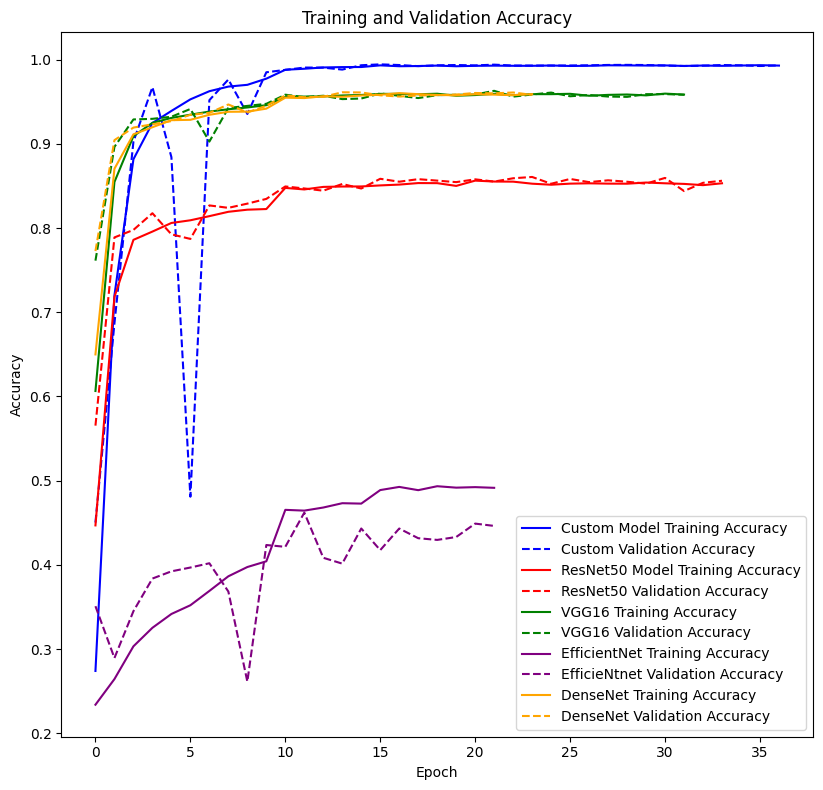

In [ ]:
# 准确度对比
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.plot(history.history['custom_accuracy'], label='Custom Model Training Accuracy', color='blue', linestyle='-')
plt.plot(history.history['val_custom_accuracy'], label='Custom Validation Accuracy', color='blue', linestyle='--')

plt.plot(history_resnet.history['custom_accuracy'], label='ResNet50 Model Training Accuracy', color='red', linestyle='-')
plt.plot(history_resnet.history['val_custom_accuracy'], label='ResNet50 Validation Accuracy', color='red', linestyle='--')

plt.plot(history_vgg16.history['custom_accuracy'], label='VGG16 Training Accuracy', color='green', linestyle='-')
plt.plot(history_vgg16.history['val_custom_accuracy'], label='VGG16 Validation Accuracy', color='green', linestyle='--')

plt.plot(history_efficientnet.history['custom_accuracy'], label='EfficientNet Training Accuracy', color='purple', linestyle='-')
plt.plot(history_efficientnet.history['val_custom_accuracy'], label='EfficieNtnet Validation Accuracy', color='purple', linestyle='--')

plt.plot(history_densenet.history['custom_accuracy'], label='DenseNet Training Accuracy', color='orange', linestyle='-')
plt.plot(history_densenet.history['val_custom_accuracy'], label='DenseNet Validation Accuracy', color='orange', linestyle='--')

plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()


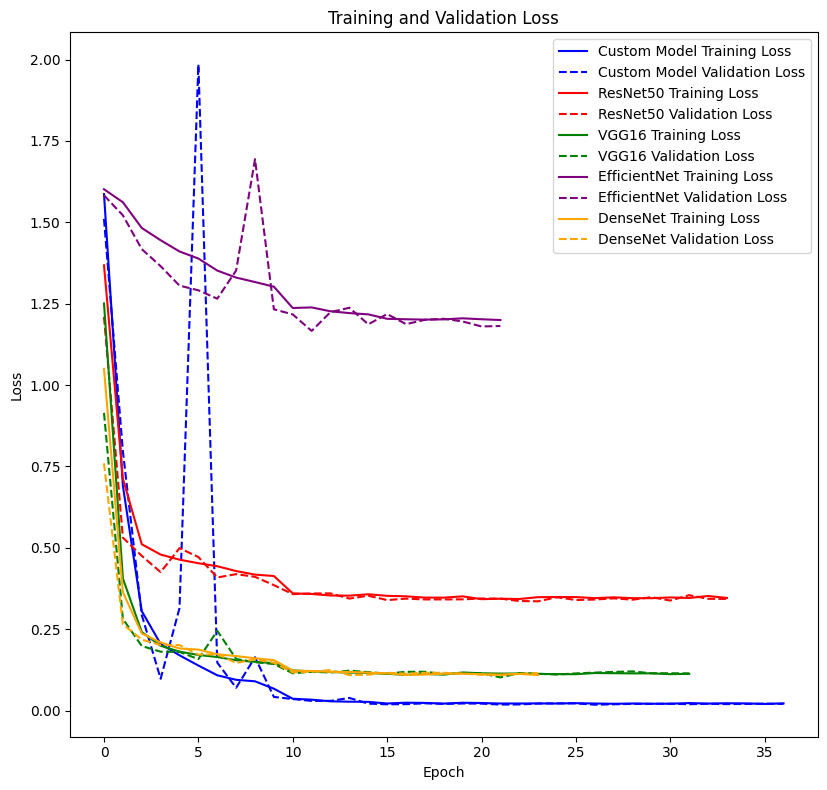

In [ ]:
plt.figure(figsize=(16, 8))

# 损失对比
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Custom Model Training Loss', color='blue', linestyle='-')
plt.plot(history.history['val_loss'], label='Custom Model Validation Loss', color='blue', linestyle='--')
plt.plot(history_resnet.history['loss'], label='ResNet50 Training Loss', color='red', linestyle='-')
plt.plot(history_resnet.history['val_loss'], label='ResNet50 Validation Loss', color='red', linestyle='--')
plt.plot(history_vgg16.history['loss'], label='VGG16 Training Loss', color='green', linestyle='-')
plt.plot(history_vgg16.history['val_loss'], label='VGG16 Validation Loss', color='green', linestyle='--')
plt.plot(history_efficientnet.history['loss'], label='EfficientNet Training Loss', color='purple', linestyle='-')
plt.plot(history_efficientnet.history['val_loss'], label='EfficientNet Validation Loss', color='purple', linestyle='--')
plt.plot(history_densenet.history['loss'], label='DenseNet Training Loss', color='orange', linestyle='-')
plt.plot(history_densenet.history['val_loss'], label='DenseNet Validation Loss', color='orange', linestyle='--')

plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

# 显示图表
plt.tight_layout()
plt.show()

In [ ]:
loss_cnn, accuracy_cnn = ensemble_model.evaluate(test_generator)
print(f"Custom Model - Loss: {loss_cnn}, Accuracy: {accuracy_cnn}")

loss_resnet, accuracy_resnet = model_resnet.evaluate(test_generator)
print(f"ResNet50 - Loss: {loss_resnet}, Accuracy: {accuracy_resnet}")

loss_vgg16, accuracy_vgg16 = model_vgg16.evaluate(test_generator)
print(f"VGG16 - Loss: {loss_vgg16}, Accuracy: {accuracy_vgg16}")

loss_efficientnet, accuracy_efficientnet = model_efficientnet.evaluate(test_generator)
print(f"EfficientNet - Loss: {loss_efficientnet}, Accuracy: {accuracy_efficientnet}")

loss_desenet, accuracy_desenet = model_densenet.evaluate(test_generator)
print(f"DenseNet201 - Loss: {loss_desenet}, Accuracy: {accuracy_desenet}")

In [ ]:
predictions_cnn = ensemble_model.predict(test_generator)
predictions_cnn = np.argmax(predictions_cnn, axis=1)

predictions_resnet = model_resnet.predict(test_generator)
predictions_resnet = np.argmax(predictions_resnet, axis=1)

predictions_vgg16 = model_vgg16.predict(test_generator)
predictions_vgg16 = np.argmax(predictions_vgg16, axis=1)

predictions_efficientnet = model_efficientnet.predict(test_generator)
predictions_efficientnet = np.argmax(predictions_efficientnet, axis=1)

predictions_densenet = model_densenet.predict(test_generator)
predictions_densenet = np.argmax(predictions_densenet, axis=1)

y_true = test_generator.classes


352/352 [==============================] - 20s 49ms/step


In [ ]:
precision_cnn, recall_cnn, f1_cnn, _ = precision_recall_fscore_support(y_true, predictions_cnn, average='weighted')
print(f"Custom Model - Precision: {precision_cnn}, Recall: {recall_cnn}, F1 Score: {f1_cnn}")

Custom Model - Precision: 0.9934529886208284, Recall: 0.9934222222222222, F1 Score: 0.9934309193797504


In [ ]:
precision_resnet, recall_resnet, f1_resnet, _ = precision_recall_fscore_support(y_true, predictions_resnet, average='weighted')
print(f"ResNet50 - Precision: {precision_resnet}, Recall: {recall_resnet}, F1 Score: {f1_resnet}")

ResNet50 - Precision: 0.8516213355222377, Recall: 0.8519111111111111, F1 Score: 0.8515607183876739


In [ ]:
precision_vgg16, recall_vgg16, f1_vgg16, _ = precision_recall_fscore_support(y_true, predictions_vgg16, average='weighted')
print(f"VGG16 - Precision: {precision_vgg16}, Recall: {recall_vgg16}, F1 Score: {f1_vgg16}")

VGG16 - Precision: 0.9561398579414565, Recall: 0.956, F1 Score: 0.9560417725226668


In [ ]:
precision_efficientnet, recall_efficientnet, f1_efficientnet, _ = precision_recall_fscore_support(y_true, predictions_efficientnet, average='weighted')
print(f"EfficientNet - Precision: {precision_efficientnet}, Recall: {recall_efficientnet}, F1 Score: {f1_efficientnet}")

EfficientNet - Precision: 0.5272359981894815, Recall: 0.4357333333333333, F1 Score: 0.3606851906008229


In [ ]:
precision_densenet, recall_densenet, f1_densenet, _ = precision_recall_fscore_support(y_true, predictions_densenet, average='weighted')
print(f"DensenetNet - Precision: {precision_densenet}, Recall: {recall_densenet}, F1 Score: {f1_densenet}")

DensenetNet - Precision: 0.9554710308651989, Recall: 0.9553777777777778, F1 Score: 0.9554133374249577


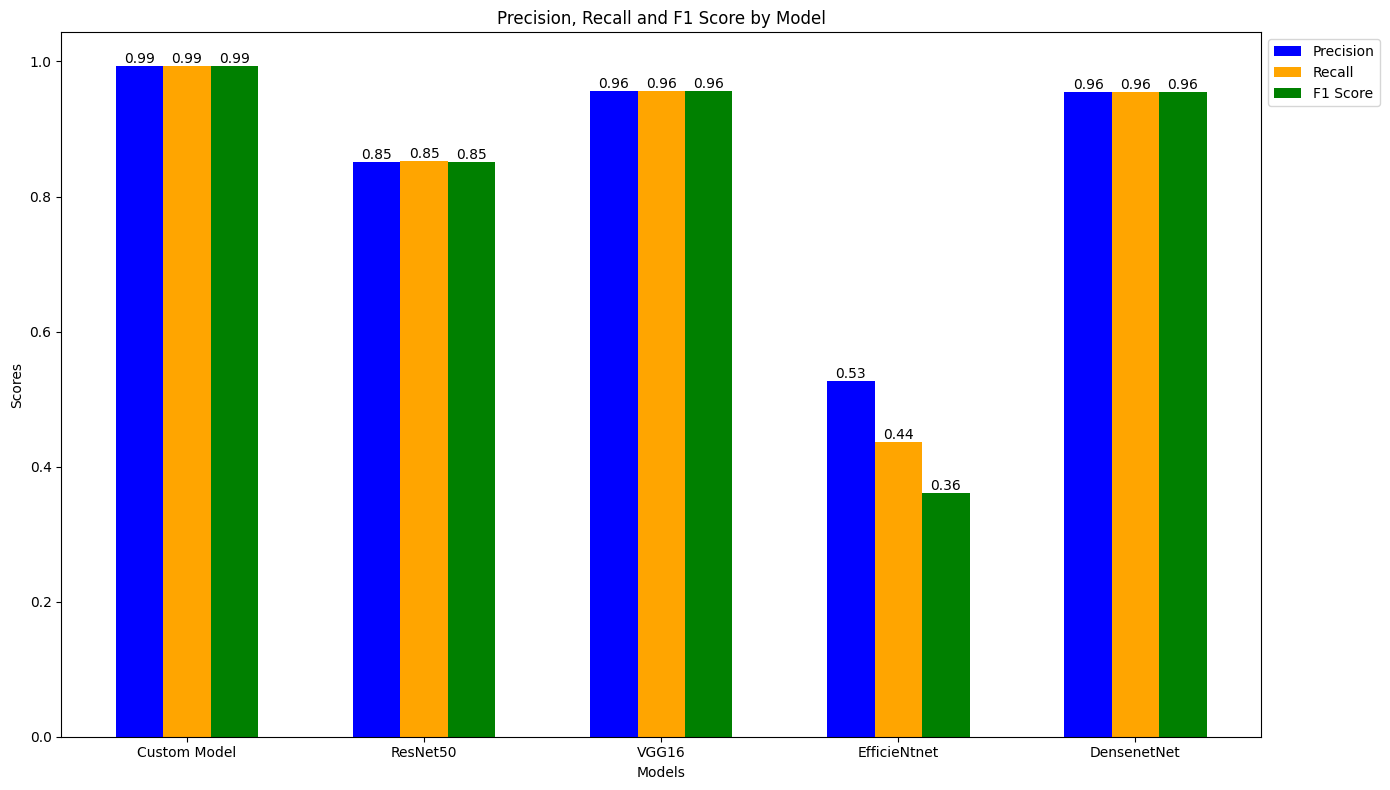

In [ ]:
# 假设你已经有了所有模型的精确度、召回率和 F1 分数
models = ['Custom Model', 'ResNet50', 'VGG16', 'EfficieNtnet', 'DensenetNet']
precisions = [precision_cnn, precision_resnet, precision_vgg16, precision_efficientnet, precision_densenet]
recalls = [recall_cnn, recall_resnet, recall_vgg16, recall_efficientnet, recall_densenet]
f1_scores = [f1_cnn, f1_resnet, f1_vgg16, f1_efficientnet, f1_densenet]

x = np.arange(len(models))  # 模型标签位置
width = 0.2  # 条形宽度

plt.figure(figsize=(14, 8))
# 画精确度的条形图
bars1 = plt.bar(x - width, precisions, width, label='Precision', color='blue')

# 画召回率的条形图
bars2 = plt.bar(x, recalls, width, label='Recall', color='orange')

# 画F1分数的条形图
bars3 = plt.bar(x + width, f1_scores, width, label='F1 Score', color='green')

# 在每个条形上添加数值标签
def add_values(bars):
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height,
                 f'{height:.2f}',
                 ha='center', va='bottom')

add_values(bars1)
add_values(bars2)
add_values(bars3)

plt.xlabel('Models')
plt.ylabel('Scores')
plt.title('Precision, Recall and F1 Score by Model')
plt.xticks(x, models)
plt.legend()
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()